In [65]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt

In [66]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [67]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize data between -1 and 1
    ])

# Load CIFAR-10 dataset
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    
# Filter out only cats (3) and dogs (5)
cat_mask = torch.tensor([label == 3 for label in dataset.targets])
dog_mask = torch.tensor([label == 5 for label in dataset.targets])
    
# Get cat and dog data
cat_data = dataset.data[cat_mask]
dog_data = dataset.data[dog_mask]
    
# Convert numpy arrays to tensors and normalize
cat_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(cat_data).permute(0, 3, 1, 2) / 127.5 - 1)
dog_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(dog_data).permute(0, 3, 1, 2) / 127.5 - 1)

Files already downloaded and verified


In [68]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim, 4*4*512),
            nn.Unflatten(1, (512, 4, 4)),
            
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 3, 3, 1, 1),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.main(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.main(x)

In [69]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [70]:
# Loss function and optimizer
criterion = nn.BCELoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [71]:
# Training parameters
batch_size = 64
latent_dim = 100
epochs = 100

In [74]:
for epoch in range(epochs):
    for i in range(0, len(cat_dataset), batch_size):
        # Handle batch sizes at the end of dataset
        batch_end = min(i + batch_size, len(cat_dataset))
        current_batch_size = batch_end - i

        # Get real images
        cat_batch = cat_dataset[i:batch_end][0].to(device)

        # Train discriminator
        optimizer_d.zero_grad()

        # Real images
        real_labels = torch.ones(current_batch_size).to(device).view(-1, 1)
        output = discriminator(cat_batch)
        loss_d_real = criterion(output, real_labels)

        # Fake images
        fake_labels = torch.zeros(current_batch_size).to(device).view(-1, 1)
        noise = torch.randn(current_batch_size, latent_dim).to(device)
        fake_images = generator(noise)
        output = discriminator(fake_images.detach())
        loss_d_fake = criterion(output, fake_labels)

        # Total loss
        loss_d = loss_d_real + loss_d_fake
        loss_d.backward()
        optimizer_d.step()

        # Train generator
        optimizer_g.zero_grad()
        noise = torch.randn(current_batch_size, latent_dim).to(device)
        fake_images = generator(noise)
        output = discriminator(fake_images)
        loss_g = criterion(output, real_labels)
        loss_g.backward()
        optimizer_g.step()
        
    # Print loss
    print(f'Epoch: {epoch + 1}/{epochs}, Loss D: {loss_d.item()}, Loss G: {loss_g.item()}')

Epoch: 1/100, Loss D: 1.7469983100891113, Loss G: 1.2611173391342163
Epoch: 2/100, Loss D: 1.4422917366027832, Loss G: 0.8062819242477417
Epoch: 3/100, Loss D: 1.4839701652526855, Loss G: 1.026470422744751
Epoch: 4/100, Loss D: 0.9130200147628784, Loss G: 1.3706156015396118
Epoch: 5/100, Loss D: 1.3204456567764282, Loss G: 1.9866626262664795
Epoch: 6/100, Loss D: 0.8557156324386597, Loss G: 1.1959543228149414
Epoch: 7/100, Loss D: 1.551461935043335, Loss G: 0.9095509052276611
Epoch: 8/100, Loss D: 1.177417278289795, Loss G: 0.5114673972129822
Epoch: 9/100, Loss D: 1.3908765316009521, Loss G: 0.7986819744110107
Epoch: 10/100, Loss D: 1.4209469556808472, Loss G: 0.724402904510498
Epoch: 11/100, Loss D: 1.30607271194458, Loss G: 0.6437323093414307
Epoch: 12/100, Loss D: 1.3225903511047363, Loss G: 1.0717357397079468
Epoch: 13/100, Loss D: 1.0453358888626099, Loss G: 1.0791046619415283
Epoch: 14/100, Loss D: 1.0457961559295654, Loss G: 1.023635745048523
Epoch: 15/100, Loss D: 1.43195438385

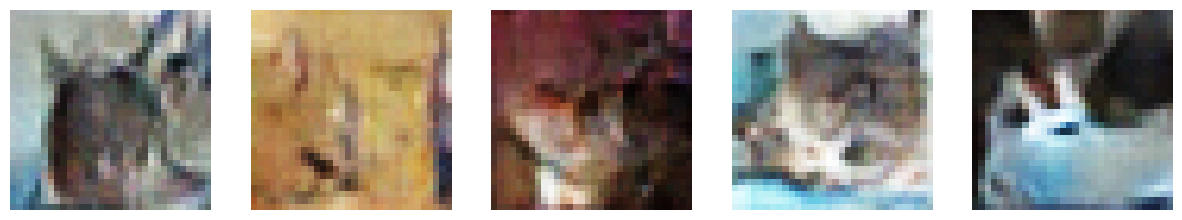

In [77]:
# Generate images
noise = torch.randn(5, latent_dim).to(device)
fake_images = generator(noise)
fake_images = fake_images.detach().cpu().numpy()

# Plot images
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axs[i].imshow((fake_images[i].transpose(1, 2, 0) + 1) / 2)
    axs[i].axis('off')
plt.show()